# Notes

- Manuscript: https://www.nature.com/articles/s41598-017-17081-y
- Data was collected from supplementary material: https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-017-17081-y/MediaObjects/41598_2017_17081_MOESM2_ESM.xlsx

In [1]:
!pip install xlrd
!pip install openpyxl

In [2]:
import math

from pathlib import Path
from copy import deepcopy

from pandas import read_excel, DataFrame

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import MutableSeq

In [3]:
data_path = Path('') / '..' / 'data' / 'cas'
cas_data_path = data_path / '41598_2017_17081_MOESM2_ESM.xlsx'

task_path = Path('') / '..' / 'tasks' / 'cas'

sheet_names = ['Positive Selection ', 'Negative Selection', 'All Count Data', 'Mutability Scores']

In [4]:
cas_sheets = read_excel(cas_data_path, sheet_name=sheet_names)

In [5]:
cas_all_counts = cas_sheets['All Count Data']

In [6]:
cas_all_counts.columns

Index(['Nucleotide Position', 'AA Position', 'WT Codon', 'WT AA', 'Domain',
       'Mutant AA', 'Mutant nucleotide', 'Mutant Codon', 'Initial Counts',
       'Initial Total Counts', 'Synonymous Mutation ', 'HindIII NdeI Cut Site',
       'WT Nucleotide', 'Error Counts', 'Error Sum Reads per Position',
       'Negative 1 Counts', 'Negative 1 Sum Reads per Position',
       'Negative 2 Counts', 'Negative 2 Sum Reads per Position',
       'Negative 3 Counts', 'Negative 3 Sum Reads per Position',
       'Positive 1 Counts', 'Positive 1 Sum Reads per Position',
       'Positive 2 Counts', 'Positive 2 Sum Reads per Position',
       'Positive 3 Counts', 'Positive 3 Sum Reads per Position',
       'Negative Counts', 'Negative Total Counts', 'Positive Counts',
       'Positive Total Counts', 'Negative Adjusted Fisher P Values',
       'Positive Adjusted Fisher P Values',
       'Log2 Fold Change after Negative Selection',
       'Log2 Fold Change after Positive Selection'],
      dtype='object

In [7]:
cas_all_counts['Domain'].value_counts()

Rec1    5952
RuvC    3684
PI      3228
HNH     1608
Rec2    1536
BH       408
Name: Domain, dtype: int64

In [8]:
# Quick and dirty check that all sequence positions are unique
t = {}

for i in cas_all_counts[['AA Position', 'WT AA']].drop_duplicates()['AA Position'].values:
    if t.get(i):
        t[i] = t[i]+1
        print(t[i])
    else:
        t[i] = 0

In [9]:
# Infer WT sequence from data
wt_sequence = ''.join(cas_all_counts[['AA Position', 'WT AA']].drop_duplicates()['WT AA'].values)

# Create Bio SeqRecord ignoring last character (a "*", most likely signifying the end of the sequence)
bio_seq = SeqRecord(seq=MutableSeq(wt_sequence[:-1]), id="CAS9", description="S. pyogenes")

with open(task_path / "cas9_sequence.fasta", "w") as output_handle:
    SeqIO.write([bio_seq], output_handle, "fasta")

<AxesSubplot:>

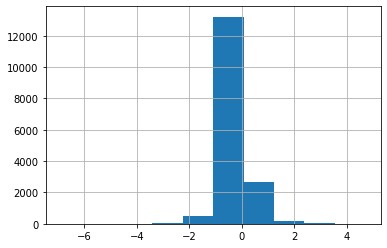

In [10]:
cas_all_counts['Log2 Fold Change after Positive Selection'].hist()

<AxesSubplot:>

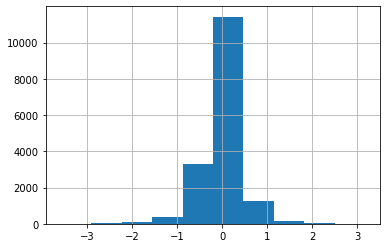

In [11]:
cas_all_counts['Log2 Fold Change after Negative Selection'].hist()

<AxesSubplot:xlabel='Negative Adjusted Fisher P Values', ylabel='Positive Adjusted Fisher P Values'>

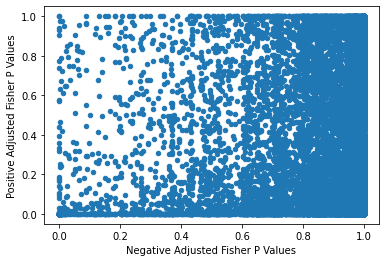

In [12]:
cas_all_counts.plot.scatter(
    x="Negative Adjusted Fisher P Values", 
    y="Positive Adjusted Fisher P Values"
)

<AxesSubplot:xlabel='Log2 Fold Change after Negative Selection', ylabel='Log2 Fold Change after Positive Selection'>

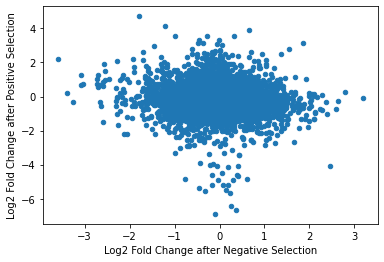

In [13]:
cas_all_counts.plot.scatter(
    x="Log2 Fold Change after Negative Selection", 
    y="Log2 Fold Change after Positive Selection"
)

In [14]:
# AA Position', 'WT Codon', 'WT AA', 'Domain','Mutant AA'

accepted_mutations = 'KILTVRNEHADGYQ*SCFPMW'

def apply_mutated_sequence(row):
    seq_copy = deepcopy(bio_seq)
    
    if str(row['Mutant AA']) in accepted_mutations:
        if str(row['Mutant AA']) == "*":
            seq_copy.seq = seq_copy.seq[0:int(row['AA Position'])-1]
        else:
            try:
                seq_copy.seq[int(row['AA Position'])-1] = row['Mutant AA']
            except:
                print(f"Couldn't edit position {int(row['AA Position'])-1}.")
    
    return str(seq_copy.seq)

cas_all_counts['mutated_AA_sequence'] = cas_all_counts.apply(apply_mutated_sequence, axis=1)

Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.


In [15]:
cas_all_counts[cas_all_counts['AA Position'] == 4]

,Nucleotide Position,AA Position,WT Codon,WT AA,Domain,Mutant AA,Mutant nucleotide,Mutant Codon,Initial Counts,Initial Total Counts,...,Positive 3 Sum Reads per Position,Negative Counts,Negative Total Counts,Positive Counts,Positive Total Counts,Negative Adjusted Fisher P Values,Positive Adjusted Fisher P Values,Log2 Fold Change after Negative Selection,Log2 Fold Change after Positive Selection,mutated_AA_sequence
36,13,4,AAA,K,RuvC,NaN,A,NaN,34741,35156,...,38312,84692,86635,124545,126410,NaN,NaN,-0.015593,0.011281,MDKKYSIGLDIGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKN...
37,14,4,AAA,K,RuvC,NaN,A,NaN,34919,34971,...,38113,86091,86204,125719,125862,NaN,NaN,0.000254,0.000252,MDKKYSIGLDIGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKN...
38,15,4,AAA,K,RuvC,NaN,A,NaN,34930,35008,...,38222,86239,86413,125861,126161,NaN,NaN,0.000310,-0.000527,MDKKYSIGLDIGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKN...
39,13,4,AAA,K,RuvC,Q,C,CAA,22,35156,...,38312,43,86635,31,126410,9.282565e-01,1.532095e-02,-0.365285,-1.004515,MDKQYSIGLDIGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKN...
40,14,4,AAA,K,RuvC,T,C,ACA,13,34971,...,38113,23,86204,52,125862,8.996652e-01,2.141399e-01,-0.523964,0.596947,MDKTYSIGLDIGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKN...
41,15,4,AAA,K,RuvC,N,C,AAC,5,35008,...,38222,11,86413,11,126161,1.000000e+00,5.684247e-01,-0.303539,-0.545940,MDKNYSIGLDIGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKN...
42,13,4,AAA,K,RuvC,E,G,GAA,18,35156,...,38312,35,86635,17,126410,9.461613e-01,1.595505e-03,-0.379157,-1.545083,MDKEYSIGLDIGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKN...
43,14,4,AAA,K,RuvC,R,G,AGA,16,34971,...,38113,39,86204,27,125862,1.000000e+00,1.814871e-02,-0.067106,-1.060584,MDKRYSIGLDIGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKN...
44,15,4,AAA,K,RuvC,K,G,AAG,13,35008,...,38222,26,86413,33,126161,9.765855e-01,7.493782e-01,-0.356007,-0.213365,MDKKYSIGLDIGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKN...
45,13,4,AAA,K,RuvC,*,T,TAA,375,35156,...,38312,1865,86635,1817,126410,2.100000e-37,8.990000e-33,1.009990,-0.582680,MDK


In [16]:
def merge_group(group):
    result = {}
    
    result['sequence'] = group.iloc[0]['mutated_AA_sequence']
    if group.iloc[0]['Domain'] == "PI":
        result['set'] = 'test'
    else:
        result['set'] = 'train'
    
    result['target'] = group['Log2 Fold Change after Positive Selection'].mean()
    
    return result

grouped_positive_selection = cas_all_counts[[
    'Log2 Fold Change after Positive Selection',
    'mutated_AA_sequence',
    'Domain'
]].dropna().groupby(['mutated_AA_sequence', 'Domain']).apply(merge_group).values

DataFrame.from_records(
    grouped_positive_selection
).to_csv(task_path / 'tasks' / "pi_domain_log_positive_selection_regression.csv", index=False)

In [17]:
def merge_group(group):
    result = {}
    
    result['sequence'] = group.iloc[0]['mutated_AA_sequence']
    if group.iloc[0]['Domain'] == "PI":
        result['set'] = 'test'
    else:
        result['set'] = 'train'
    
    result['target'] = group['Log2 Fold Change after Negative Selection'].mean()
    
    return result

grouped_negative_selection = cas_all_counts[[
    'Log2 Fold Change after Negative Selection',
    'mutated_AA_sequence',
    'Domain'
]].dropna().groupby(['mutated_AA_sequence', 'Domain']).apply(merge_group).values

DataFrame.from_records(
    grouped_negative_selection
).to_csv(task_path / 'tasks' / "pi_domain_log_negative_selection_regression.csv", index=False)

In [ ]:
#########################################################################################################
#########################################################################################################
############################################## OLDER CELLS ##############################################
#########################################################################################################
#########################################################################################################

In [13]:
def get_mutation_matrix(cas_all_counts_dataframe, score_column):
    
    possible_mutations = cas_all_counts_dataframe['Mutant AA'].unique()

    ordered_change_impact = list()

    def assign_score(group, score_column):
        group_score = {}
        group_AAs = group['Mutant AA'].unique()
        for AA in possible_mutations:
            if AA in group_AAs:
                group_score[AA] = group[group['Mutant AA'] == AA][score_column].values[0]
            else:
                group_score[AA] = math.nan
        ordered_change_impact.append(group_score)

    cas_all_counts_dataframe[[
        'AA Position', 'Mutant AA', 
        'Log2 Fold Change after Positive Selection', 'Log2 Fold Change after Negative Selection'
    ]].groupby("AA Position").apply(
        lambda x: assign_score(x, score_column)
    )
    
    mutation_matrix = DataFrame(ordered_change_impact, index=list(wt_sequence)).T
    
    return mutation_matrix

In [14]:
positive_mutation_matrix = get_mutation_matrix(cas_all_counts, 'Log2 Fold Change after Positive Selection')
negative_mutation_matrix = get_mutation_matrix(cas_all_counts, 'Log2 Fold Change after Negative Selection')

positive_mutation_matrix.to_csv(task_path / 'positive_mutation_matrix.csv', index=True)
negative_mutation_matrix.to_csv(task_path / 'negative_mutation_matrix.csv', index=True)

In [28]:
scores = list()

accepted_mutations = 'KILTVRNEHADGYQ*SCFPMW'
i = 0

def mutate_sequence(col):
    seq_copy = deepcopy(bio_seq)
    global i
    
    for mutation in accepted_mutations:
        mutation_value = col['*']
        if not math.isnan(mutation_value):
            try:
                seq_copy.seq[i] = mutation

                scores.append({
                    'sequence': str(seq_copy.seq), 
                    'target': mutation_value
                })
            except:
                print(f"Couldn't edit position {i}.")
    
    i = i + 1

positive_mutation_matrix.apply(mutate_sequence)

Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.
Couldn't edit position 1390.


M    None
D    None
K    None
K    None
Y    None
     ... 
P    None
D    None
Y    None
A    None
*    None
Length: 1391, dtype: object